In [1]:
pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Active Learning**

In [2]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

In [4]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

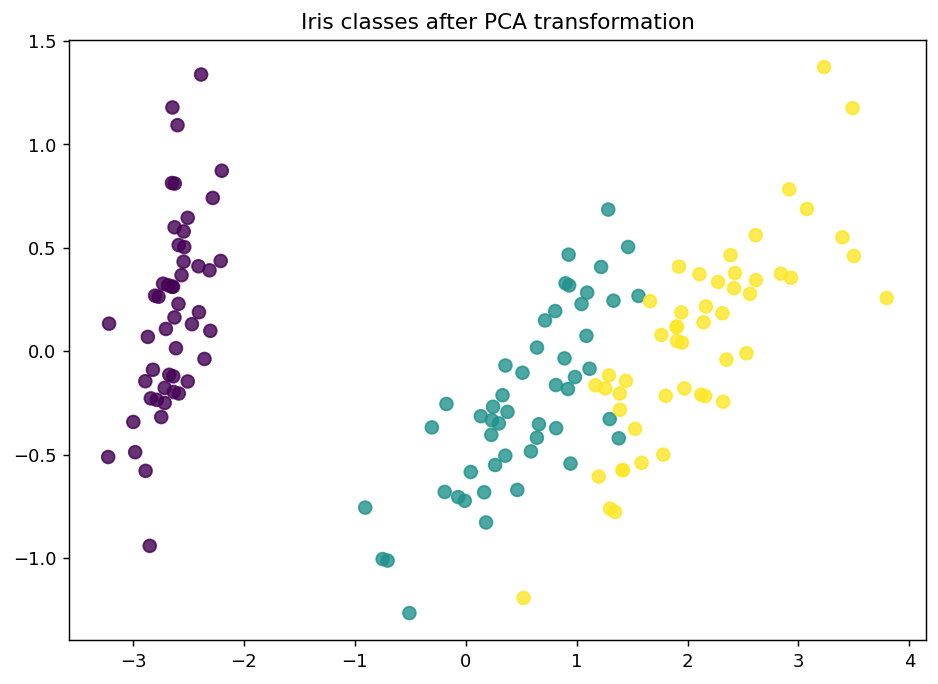

In [5]:
from matplotlib import colors
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10,)
plt.title('Iris classes after PCA transformation')
plt.show()

In [6]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner

# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=3)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [8]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

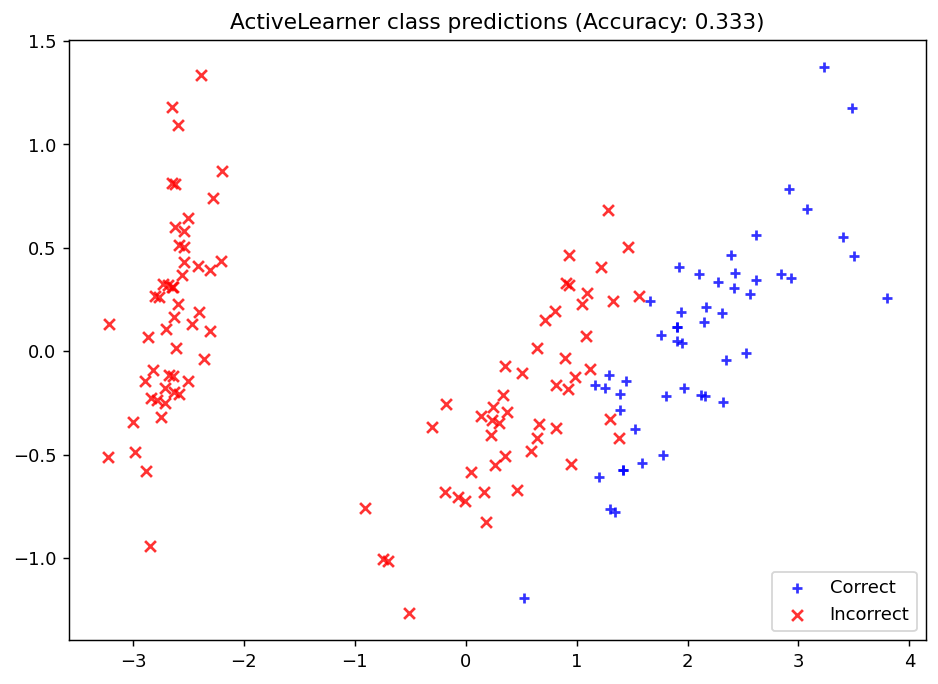

In [9]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='red', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [10]:
N_QUERIES = 20
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267


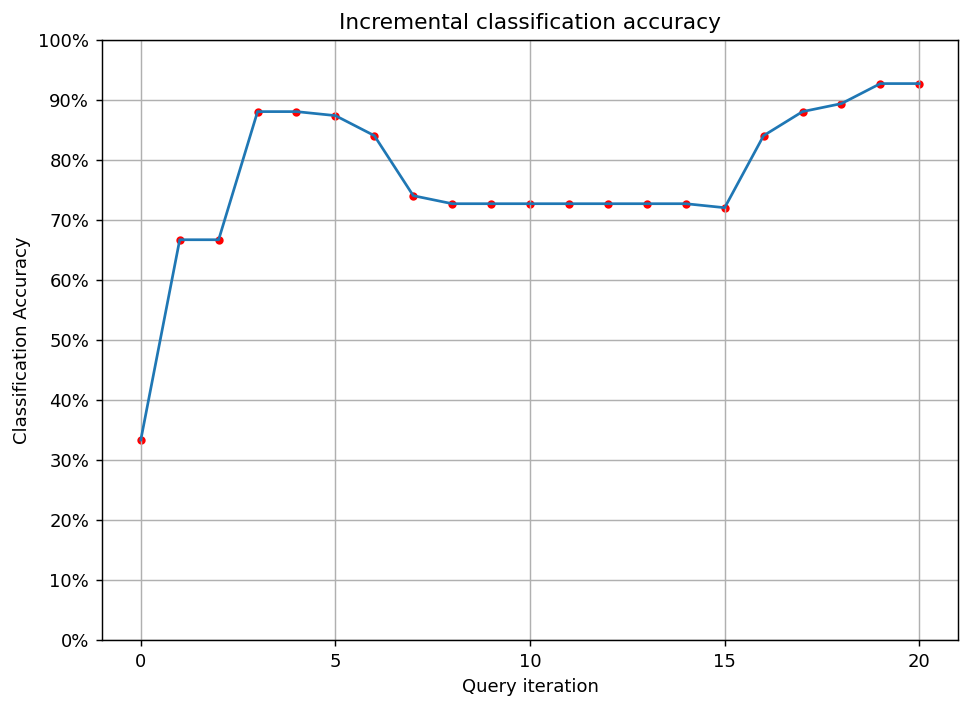

In [11]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13, c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

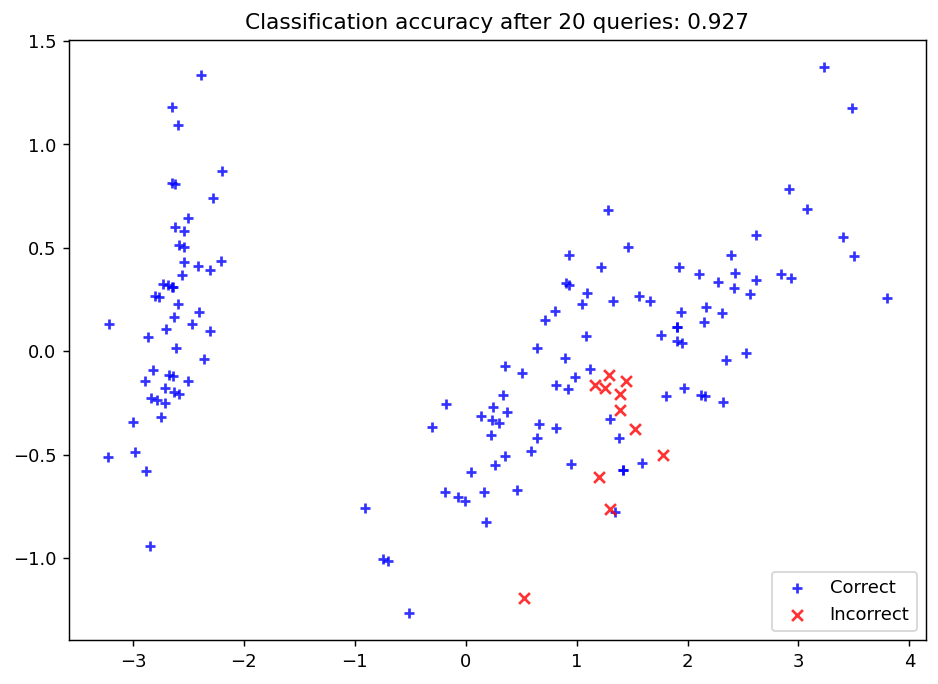

In [12]:
  # Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Query by committee**

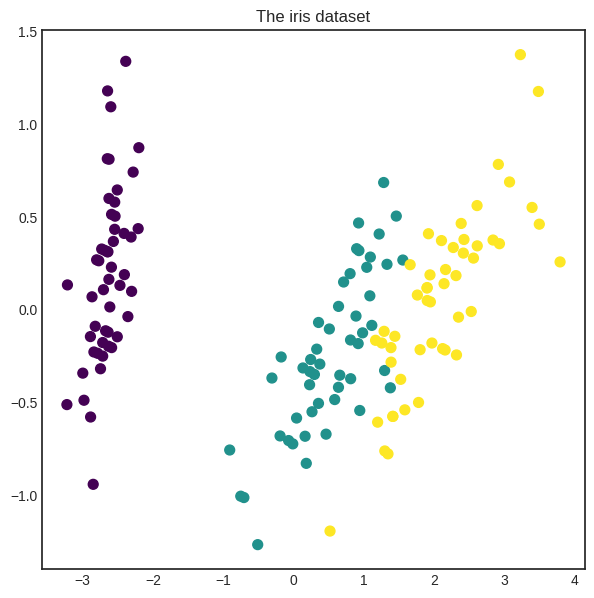

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

# loading the iris dataset
iris = load_iris()

# visualizing the classes
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    pca = PCA(n_components=2).fit_transform(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=iris['target'], cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()

In [14]:
from copy import deepcopy

# generate the pool
X_pool = deepcopy(iris['data'])
y_pool = deepcopy(iris['target'])

In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner, Committee

# initializing Committee members
n_members = 2
learner_list = list()

for member_idx in range(n_members):
    # initial training data
    n_initial = 2
    train_idx = np.random.choice(range(X_pool.shape[0]), size=n_initial, replace=False)
    X_train = X_pool[train_idx]
    y_train = y_pool[train_idx]

    # creating a reduced copy of the data with the known instances removed
    X_pool = np.delete(X_pool, train_idx, axis=0)
    y_pool = np.delete(y_pool, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

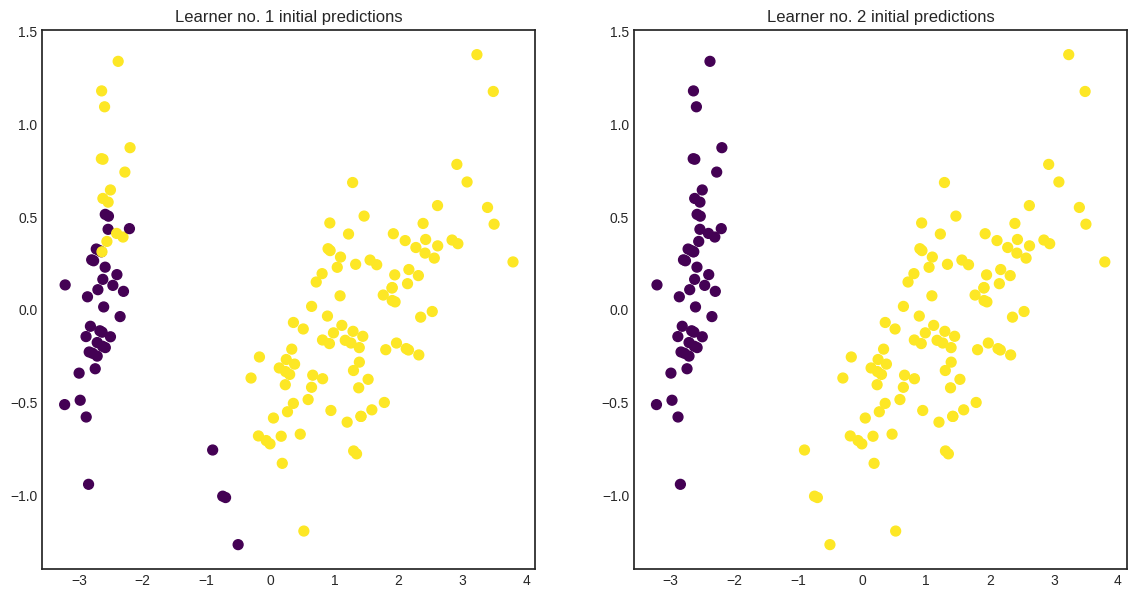

In [16]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d initial predictions' % (learner_idx + 1))
    plt.show()

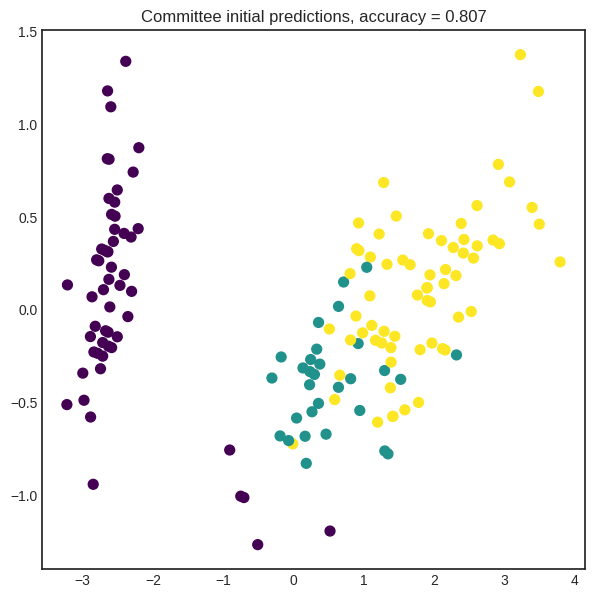

In [17]:
unqueried_score = committee.score(iris['data'], iris['target'])

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee initial predictions, accuracy = %1.3f' % unqueried_score)
    plt.show()

In [18]:
performance_history = [unqueried_score]

# query by committee
n_queries = 30
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=y_pool[query_idx].reshape(1, )
    )
    performance_history.append(committee.score(iris['data'], iris['target']))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)

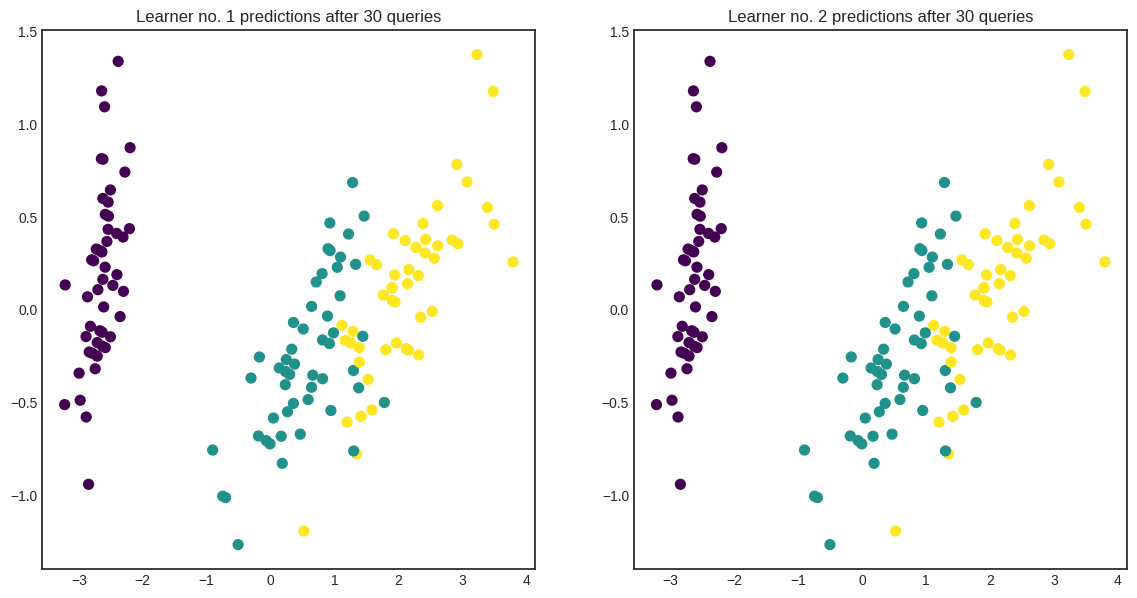

In [19]:
# visualizing the final predictions per learner
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(n_members*7, 7))
    for learner_idx, learner in enumerate(committee):
        plt.subplot(1, n_members, learner_idx + 1)
        plt.scatter(x=pca[:, 0], y=pca[:, 1], c=learner.predict(iris['data']), cmap='viridis', s=50)
        plt.title('Learner no. %d predictions after %d queries' % (learner_idx + 1, n_queries))
    plt.show()

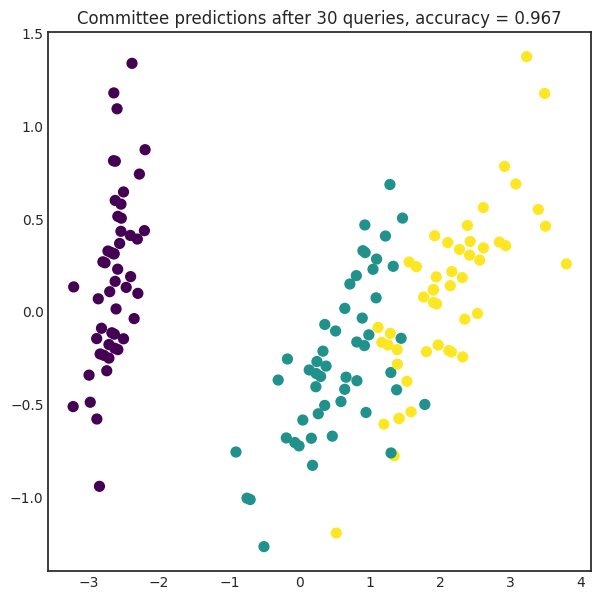

In [20]:
# visualizing the Committee's predictions
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = committee.predict(iris['data'])
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=50)
    plt.title('Committee predictions after %d queries, accuracy = %1.3f'
              % (n_queries, committee.score(iris['data'], iris['target'])))

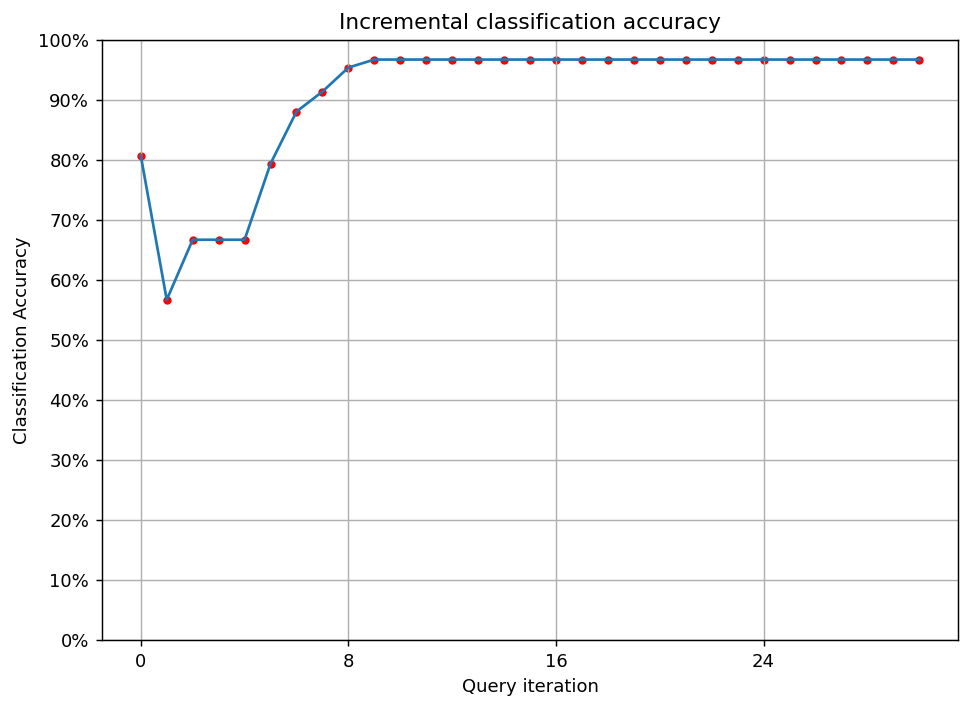

In [21]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13, c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

# **Margin** sampling strategy

In [22]:
from modAL.uncertainty import margin_sampling
iris = load_iris()
X_raw3 = iris['data']
y_raw3 = iris['target']

In [23]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw3)

In [24]:
# Isolate our examples for our labeled dataset.
n_labeled_examples3 = X_raw3.shape[0]
training_indices3 = np.random.randint(low=0, high=n_labeled_examples3, size=3)

X_train3 = X_raw3[training_indices3]
y_train3 = y_raw3[training_indices3]

# Isolate the non-training examples we'll be querying.
X_pool3 = np.delete(X_raw3, training_indices3, axis=0)
y_pool3 = np.delete(y_raw3, training_indices3, axis=0)

In [25]:
learner = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors=3),
    query_strategy=margin_sampling,
    X_training=X_train3, y_training=y_train3
)

In [26]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

predictions


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

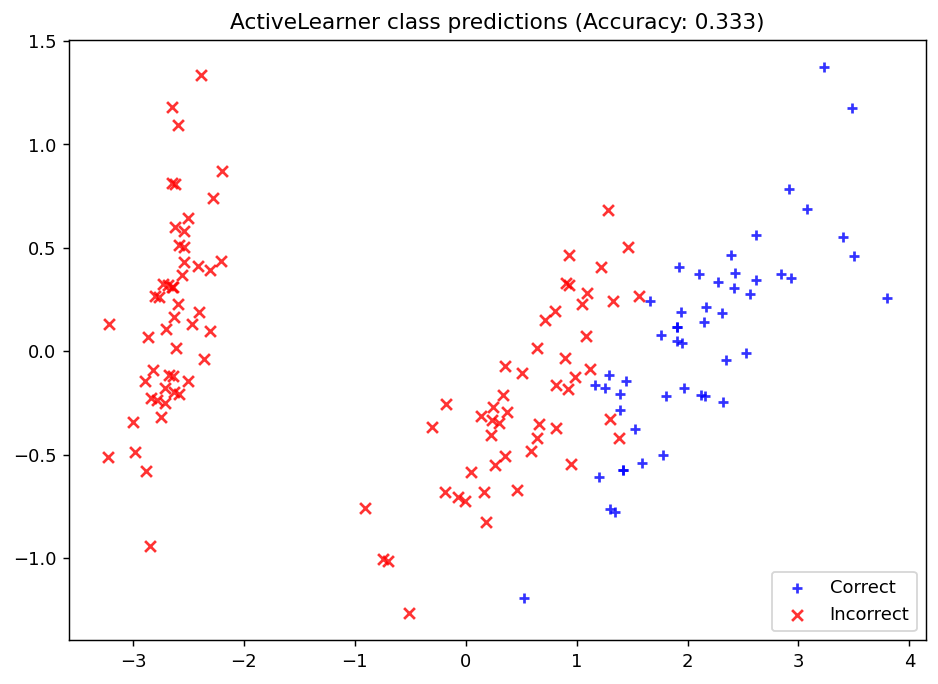

In [27]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw3, y_raw3)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [28]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool3)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool3[query_index].reshape(1, -1), y_pool3[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool3, y_pool3 = np.delete(X_pool3, query_index, axis=0), np.delete(y_pool3, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw3, y_raw3)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267
Accuracy after query 21: 0.9267
Accuracy after query 22: 0.9067
Accuracy after query 23: 0.9400
Accuracy after query 24: 0.9467
Accuracy after query 25: 0.9467
Accuracy after query 26: 0.9467
Accuracy after query 27: 0.9467
Accuracy after query 28: 0.9467
Accuracy after query 29: 0.9667
Accuracy after query 30: 0.9733


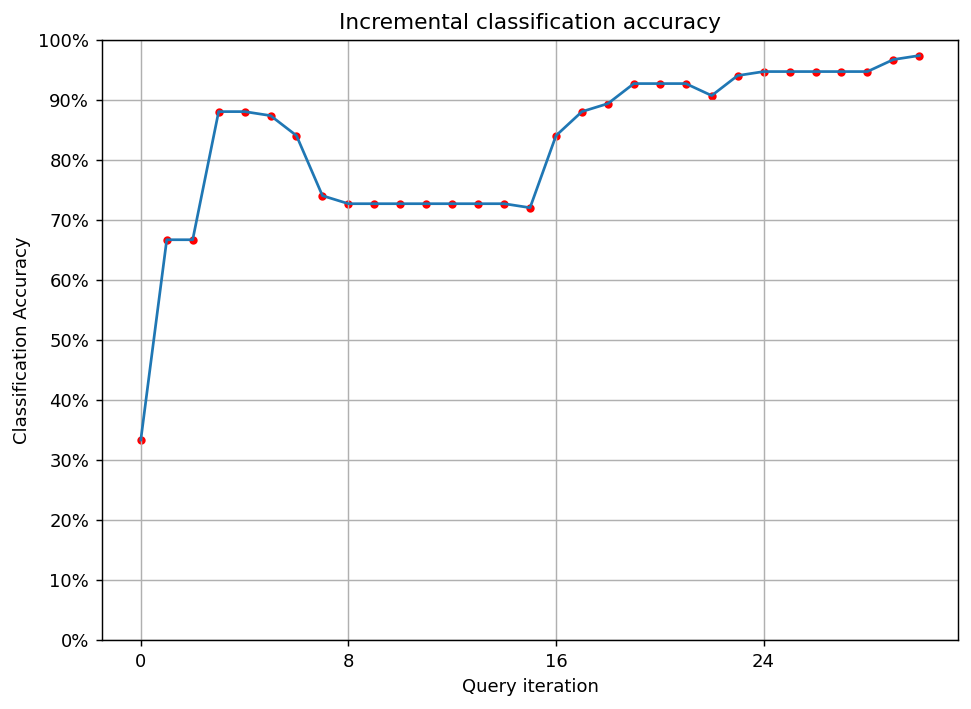

In [29]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13,c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

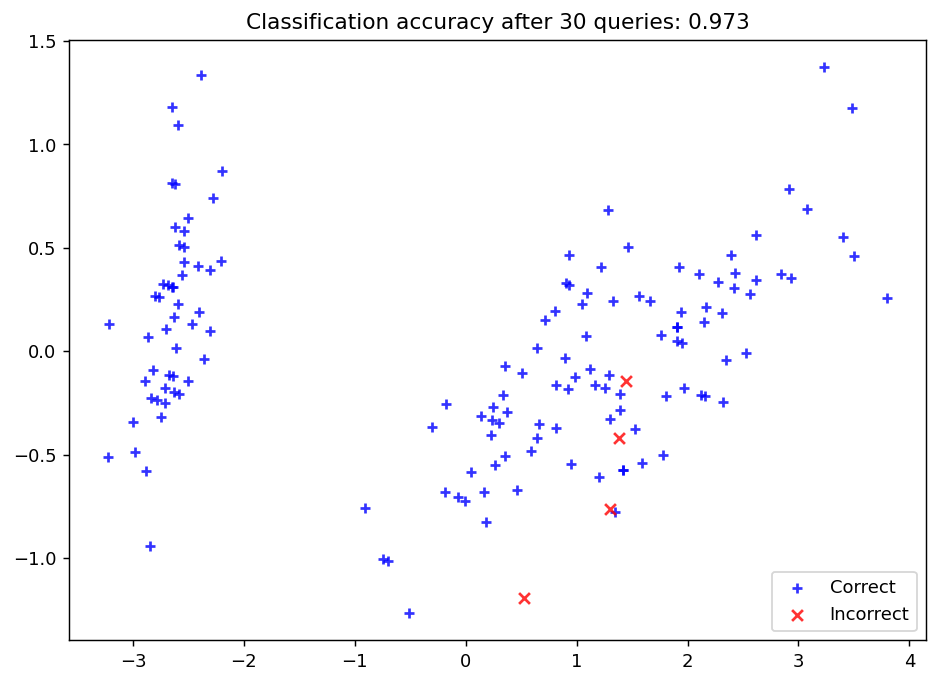

In [30]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Random sampling strategy**

In [31]:
iris = load_iris()
X_raw1 = iris['data']
y_raw1 = iris['target']

In [32]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw1)

In [33]:
# Isolate our examples for our labeled dataset.
n_labeled_examples1 = X_raw1.shape[0]
training_indices1 = np.random.randint(low=0, high=n_labeled_examples1, size=3)

X_train1 = X_raw1[training_indices1]
y_train1 = y_raw1[training_indices1]

# Isolate the non-training examples we'll be querying.
X_pool1 = np.delete(X_raw1, training_indices1, axis=0)
y_pool1 = np.delete(y_raw1, training_indices1, axis=0)

In [34]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool1[query_idx]

learner = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors=3),
    query_strategy=random_sampling,
    X_training=X_train1, y_training=y_train1
)

In [35]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

predictions


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

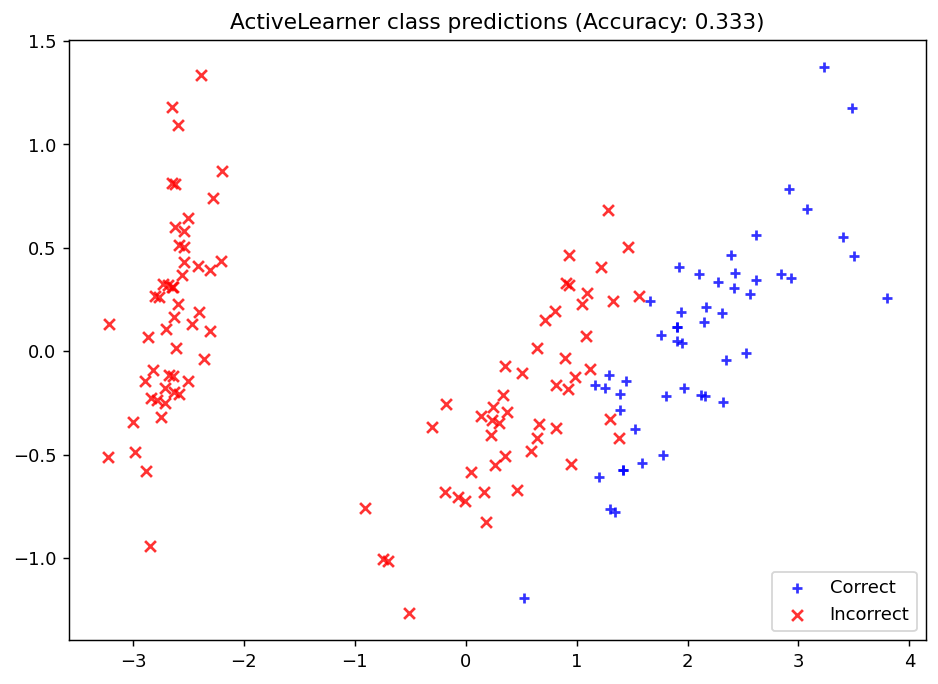

In [36]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw1, y_raw1)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [37]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool1)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool1[query_index].reshape(1, -1), y_pool1[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool1, y_pool1 = np.delete(X_pool1, query_index, axis=0), np.delete(y_pool1, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw1, y_raw1)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.5600
Accuracy after query 2: 0.5600
Accuracy after query 3: 0.5400
Accuracy after query 4: 0.5933
Accuracy after query 5: 0.5933
Accuracy after query 6: 0.6200
Accuracy after query 7: 0.6267
Accuracy after query 8: 0.6200
Accuracy after query 9: 0.6200
Accuracy after query 10: 0.9533
Accuracy after query 11: 0.9667
Accuracy after query 12: 0.9667
Accuracy after query 13: 0.9400
Accuracy after query 14: 0.9400
Accuracy after query 15: 0.9400
Accuracy after query 16: 0.9400
Accuracy after query 17: 0.9533
Accuracy after query 18: 0.9600
Accuracy after query 19: 0.9600
Accuracy after query 20: 0.9667
Accuracy after query 21: 0.9667
Accuracy after query 22: 0.9667
Accuracy after query 23: 0.9667
Accuracy after query 24: 0.9800
Accuracy after query 25: 0.9800
Accuracy after query 26: 0.9800
Accuracy after query 27: 0.9733
Accuracy after query 28: 0.9733
Accuracy after query 29: 0.9733
Accuracy after query 30: 0.9733


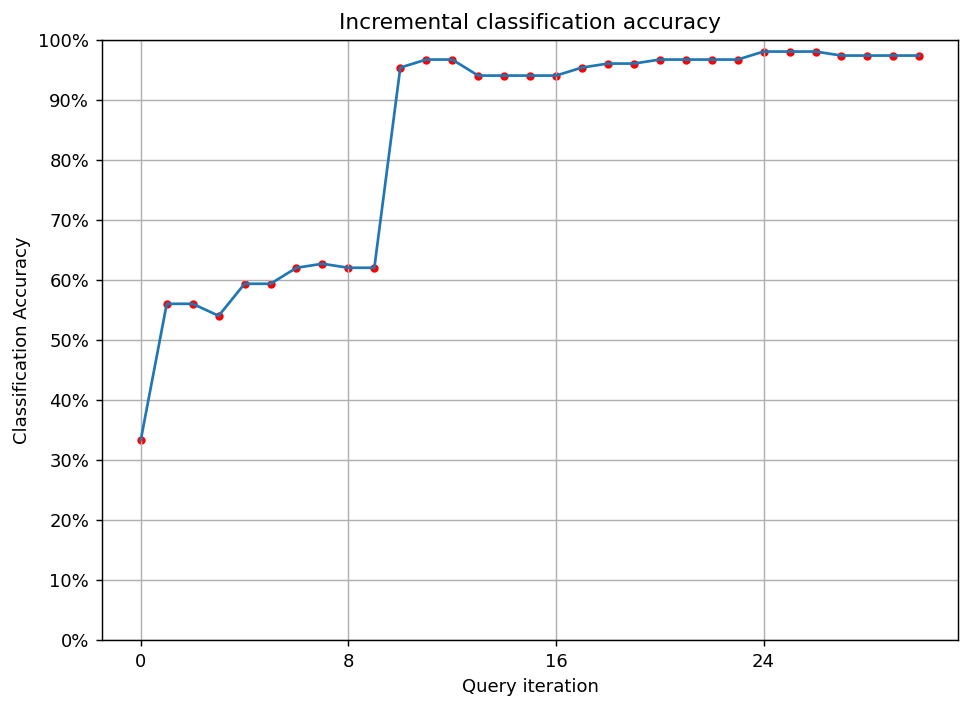

In [38]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13, c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

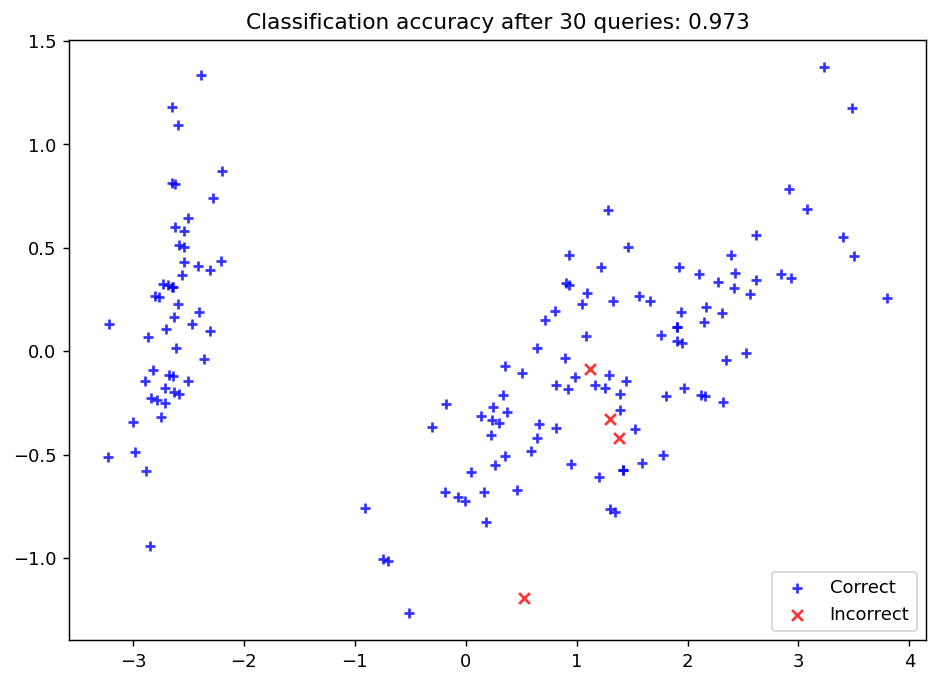

In [39]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Entropy sampling strategy**


In [40]:
from modAL.uncertainty import entropy_sampling

In [41]:
iris = load_iris()
X_raw2 = iris['data']
y_raw2 = iris['target']

In [42]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw2)

In [43]:
# Isolate our examples for our labeled dataset.
n_labeled_examples2 = X_raw2.shape[0]
training_indices2 = np.random.randint(low=0, high=n_labeled_examples2, size=3)

X_train2 = X_raw2[training_indices2]
y_train2 = y_raw2[training_indices2]

# Isolate the non-training examples we'll be querying.
X_pool2 = np.delete(X_raw2, training_indices2, axis=0)
y_pool2 = np.delete(y_raw2, training_indices2, axis=0)

In [44]:
learner = ActiveLearner(
    estimator = KNeighborsClassifier(n_neighbors=3),
    query_strategy=entropy_sampling,
    X_training=X_train2, y_training=y_train2
)

In [45]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw2)
is_correct = (predictions == y_raw2)

predictions


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

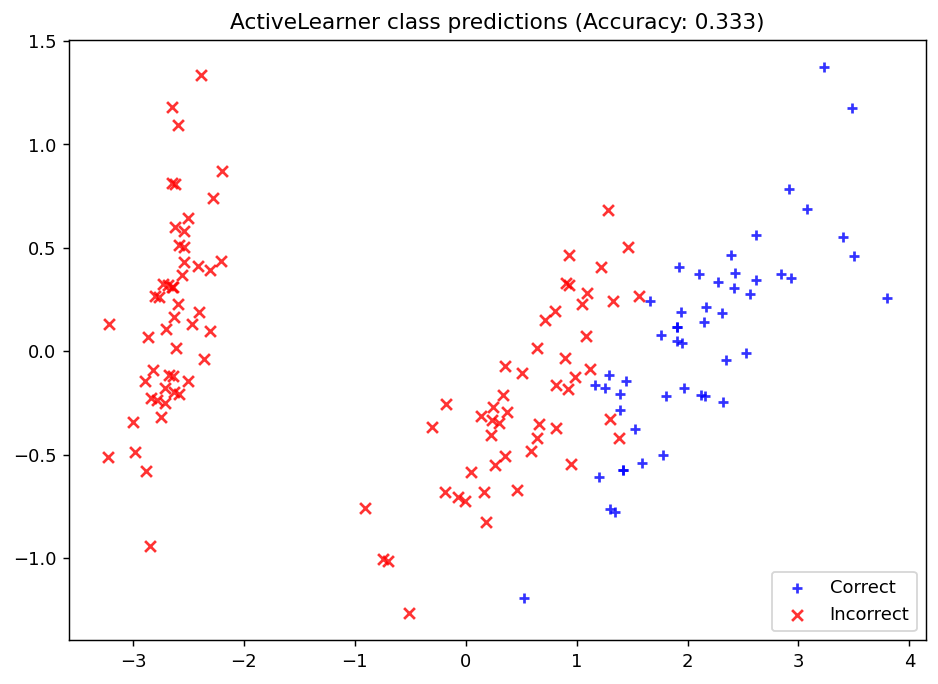

In [46]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw2, y_raw2)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [47]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool2)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool2[query_index].reshape(1, -1), y_pool2[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool2, y_pool2 = np.delete(X_pool2, query_index, axis=0), np.delete(y_pool2, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw2, y_raw2)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.6667
Accuracy after query 2: 0.6667
Accuracy after query 3: 0.8800
Accuracy after query 4: 0.8800
Accuracy after query 5: 0.8733
Accuracy after query 6: 0.8400
Accuracy after query 7: 0.7400
Accuracy after query 8: 0.7267
Accuracy after query 9: 0.7267
Accuracy after query 10: 0.7267
Accuracy after query 11: 0.7267
Accuracy after query 12: 0.7267
Accuracy after query 13: 0.7267
Accuracy after query 14: 0.7267
Accuracy after query 15: 0.7200
Accuracy after query 16: 0.8400
Accuracy after query 17: 0.8800
Accuracy after query 18: 0.8933
Accuracy after query 19: 0.9267
Accuracy after query 20: 0.9267
Accuracy after query 21: 0.9267
Accuracy after query 22: 0.9067
Accuracy after query 23: 0.9400
Accuracy after query 24: 0.9467
Accuracy after query 25: 0.9467
Accuracy after query 26: 0.9467
Accuracy after query 27: 0.9467
Accuracy after query 28: 0.9467
Accuracy after query 29: 0.9667
Accuracy after query 30: 0.9733


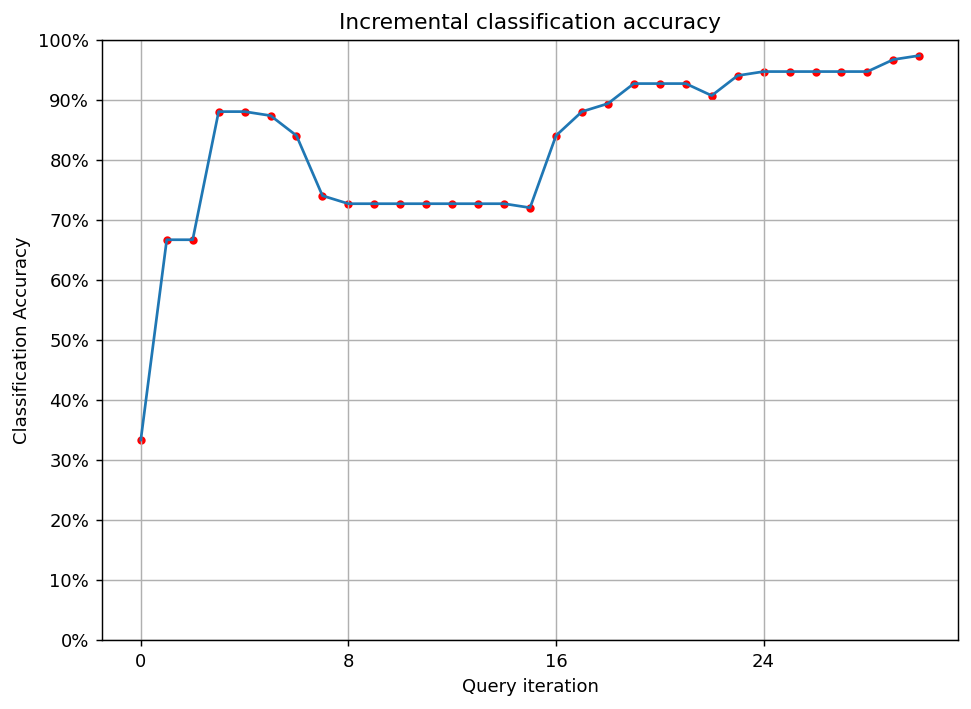

In [48]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13,c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

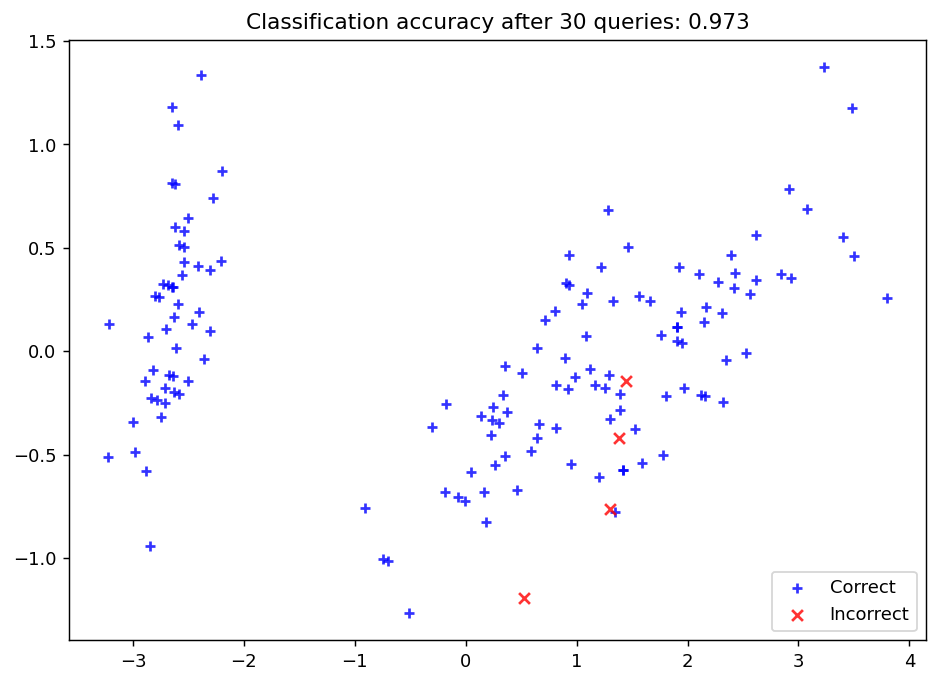

In [49]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw2)
is_correct = (predictions == y_raw2)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# **Uncertainity sampling**

In [53]:
# Specify our core estimator along with it's active learning model.
knn = KNeighborsClassifier(n_neighbors=2)
learner = ActiveLearner(estimator=knn, X_training=X_train, y_training=y_train)

In [54]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

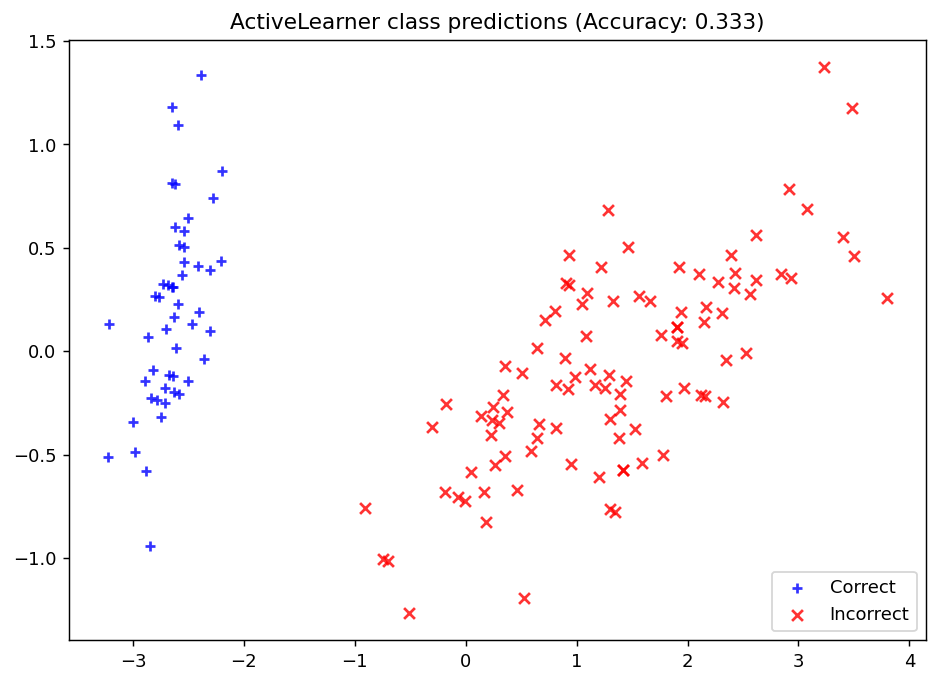

In [55]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [56]:
N_QUERIES = 30
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.3333
Accuracy after query 2: 0.6533
Accuracy after query 3: 0.6667
Accuracy after query 4: 0.6667
Accuracy after query 5: 0.6667
Accuracy after query 6: 0.6667
Accuracy after query 7: 0.6667
Accuracy after query 8: 0.6667
Accuracy after query 9: 0.6667
Accuracy after query 10: 0.6667
Accuracy after query 11: 0.6667
Accuracy after query 12: 0.6667
Accuracy after query 13: 0.6667
Accuracy after query 14: 0.6667
Accuracy after query 15: 0.6667
Accuracy after query 16: 0.6667
Accuracy after query 17: 0.6667
Accuracy after query 18: 0.6667
Accuracy after query 19: 0.6667
Accuracy after query 20: 0.6667
Accuracy after query 21: 0.6667
Accuracy after query 22: 0.6667
Accuracy after query 23: 0.6667
Accuracy after query 24: 0.6667
Accuracy after query 25: 0.6667
Accuracy after query 26: 0.6667
Accuracy after query 27: 0.6667
Accuracy after query 28: 0.6667
Accuracy after query 29: 0.6667
Accuracy after query 30: 0.6667


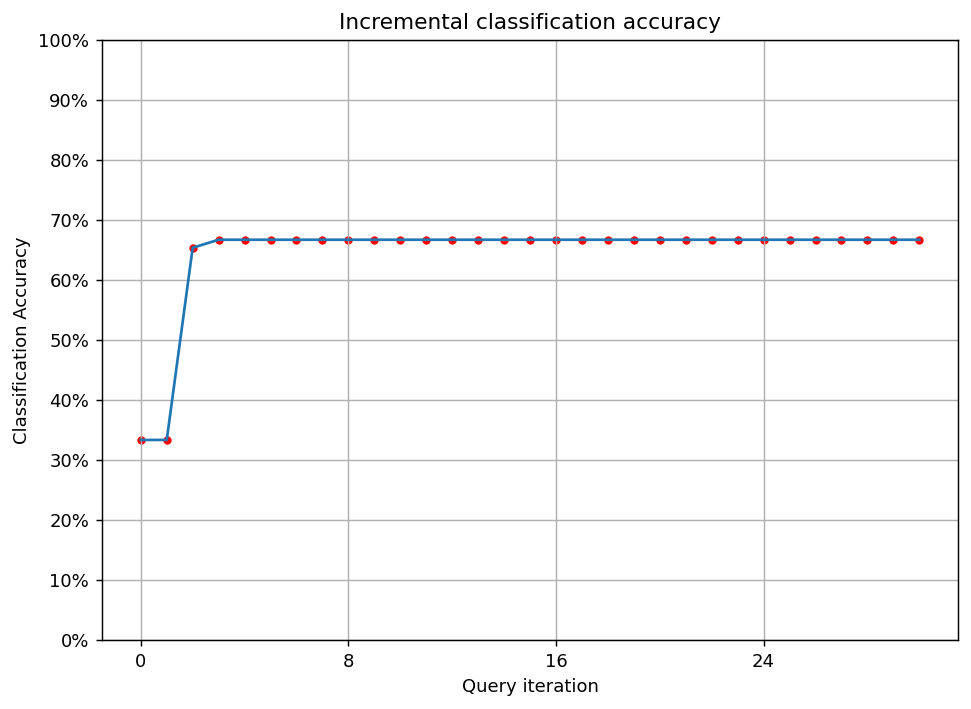

In [57]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13,c='r')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

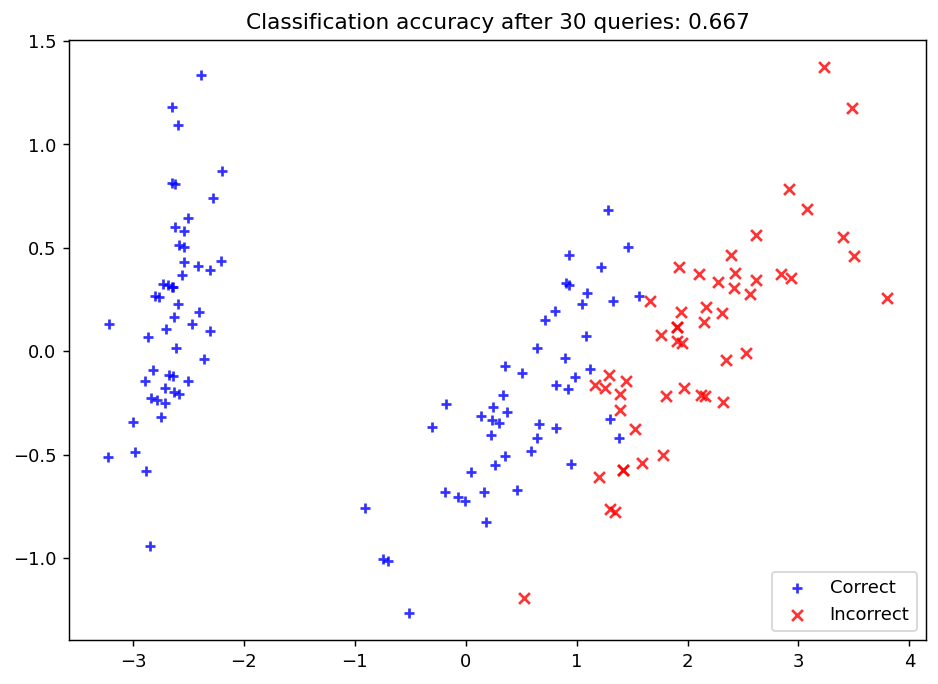

In [58]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='b', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()